<a id="top"></a>

# Creating a Color-Magnitude Diagram for Messier 13
***

## Learning Goals 
By the end of this tutorial, you will:

- Understand how to use `astroquery.mast` to download the SDSS Legacy Imaging Survey Data from the MAST archive.
- Plot a Color-Magnitude Diagram of Messier 13
- Calculate the distance to Messier 13 using the Gaia catalog
- Approximate the age of Messier 13 using stellar isochrones

## Table of Contents
* [Introduction](#introduction)
* [Imports](#imports)
* [Accessing SDSS Legacy Imaging Survey Data from MAST](#accessing-sdss-legacy-imaging-survey-data-from-mast)
    * [Querying SDSS Legacy Imaging Survey](#querying-sdss-legacy-imaging-survey) 
    * [Sampling SDSS Legacy Imaging Survey for M13](#sampling-sdss-legacy-imaging-survey-for-m13)
    * [Downloading Data Products](#downloading-sdss-legacy-imaging-survey-data-products)
    * [Creating a Color-Magnitude Diagram](#creating-a-color-magnitude-diagram-of-m13)
* [Finding the Distance to M13 Using Gaia](#finding-the-distance-to-m13-using-data-from-gaia)
* [Determining the Age of M13 Using Stellar Isochrone Matching](#determining-the-age-of-m13-using-stellar-isochrone-matching)
* [End of Tutorial](#end-of-tutorial)
* [Exercises](#exercises)
* [Exercise Solutions](#exercise-solutions)
* [Additional Resources](#addtional-resources)
* [Citations](#citations)
* [About this Notebook](#about-this-notebook)

## Introduction 
The Hertzsprung-Russell (HR) Diagram was independently discovered by Ejnar Hertzsprung and Henry Norris Russell in the early 20th century. This diagram effectively plots a star's theoretical luminosity against its temperature.
By examining the position of stars on the HR diagram, we can infer stellar properties such as age, metallicity, or mass. An HR Diagram is also useful for tracking the life cycle of stars. Stars in their hydrogen-core burning phases evolve leftwards on the HR diagram. Eventually, they leave the main sequence to start their red giant phases and move upwards as they begin burning helium in their cores [[1]](https://astronomy.swin.edu.au/cosmos/h/hertzsprung-russell+diagram).

An observational variation of the HR Diagram is the *Color-Magnitude Diagram* (CMD), which uses color (a proxy for temperature) and magnitude (a proxy for luminosity). We can use photometric data from a star cluster to create a CMD, and then estimate the age by comparing the main sequence tracks and red giant branch to theoretical isochrones — curves that represent stars of the same age but with different masses, mapping their expected positions at various evolutionary stages. For example, an older cluster will have more stars on the red giant branch whereas a younger cluster will have more stars on the main sequence. The transition between the two evolutionary stages, called the *Main Sequence Turn-Off*, is the key to determining the age of a stellar cluster [[2]](https://astronomyonline.org/Astrophotography/CMDDiagram.asp)

<figure style="text-align: center;">
  <img src="https://www.researchgate.net/profile/Lawrence-Krauss/publication/10964320/figure/fig2/AS:601699240644635@1520467686671/A-schematic-color-magnitude-diagram-for-a-typical-globular-cluster-33-showing-the.png" alt="Color Magnitude Diagram for Globular Clusters" width="400px" height="450px"/>
  <figcaption>
  Color Magnitude Diagram for Global Clusters from L. Krauss and B. Chaboyer
  <a href="https://www.science.org/doi/10.1126/science.1075631" target="_blank">[3].</a>
  </figcaption>
</figure>

Messier 13 (M13) is a globular cluster located in the constellation Hercules [[4]](https://science.nasa.gov/mission/hubble/science/explore-the-night-sky/hubble-messier-catalog/messier-13/). M13 is estimated to contain over 100,000 stars with a total metallicity ([Fe/H]) of approximately -1.33 dex [[5]](https://academic.oup.com/mnras/article/404/3/1203/1049211?login=true#92596831). This is consistent with the ancient stellar populations found in other globular clusters [[6]](https://science.nasa.gov/universe/star-clusters-inside-the-universes-stellar-collections/). 

In this notebook, we'll estimate the age of M13 using photometric data from the Sloan Digital Sky Survey's (SDSS) Legacy Imaging Survey and stellar isochrones from the PARSEC database [[7]](https://www.aanda.org/articles/aa/full_html/2022/09/aa44166-22/aa44166-22.html). By plotting isochrone tracks for a range of ages and comparing them to the observed stellar distribution of M13, we can identify the isochrone that best fits the cluster's data and thereby estimate its age.


## Imports 
The main packages and their use-cases in this tutorial are as follows:
- *numpy* to handle array functions
- *matplotlib.pyplot* for plotting data
- *matplotlib.image* for displaying .jpg images
- *astroquery.mast.Observations* to access SDSS data from MAST
- *astroquery.mast.Catalogs* to access data Gaia data from MAST
- *pandas* to handle large data tables
- *astropy.io.fits* for accessing FITS files

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from astroquery.mast import Observations
from astroquery.mast import Catalogs
import pandas as pd
import astropy.io.fits as fits

If you're not sure if you have the required versions of packages installed on your device, you can run the following cell:

In [2]:
with open("requirements.txt") as f:
    print(f"Required packages for this notebook:\n{f.read()}")

Required packages for this notebook:
pandas >= 2.3.0
astroquery >= 0.4.9
matplotlib >= 3.9.1
numpy >= 1.26.4



To ensure these requirements are installed, you can run the following command in the terminal:
```bash
pip install -r requirements.txt
```

*** 
## Accessing SDSS Legacy Imaging Survey Data from MAST 

The [Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) hosts a large array of data from several telescope missions. In this tutorial, we will be specifically focusing on data from the Sloan Digital Sky Survey's (SDSS) Imaging Survey. 

The [SDSS Legacy Imaging Survey](https://www.sdss.org/dr18/imaging/) was the first SDSS survey completed! Beginning in 1998, the SDSS Legacy Imaging Survey captured around 35,000 square degrees of images until 2009, which covers about one-third of the whole sky. To do this, the survey took millions of 10 by 13 arcminute pictures (called "fields"). Not only does the SDSS Legacy Imaging Survey data at MAST provide users with preview images in .jpg format, but it also has photometric data in all five broad band SDSS filters (u, g, r, i, and z). For more information about the data and products from the SDSS Legacy Imaging Survey, you can check out the [SDSS Imaging Archive Manual](https://outerspace.stsci.edu/display/SDSS/Legacy+Imaging). 

### Querying SDSS Legacy Imaging Survey

You can query data from MAST using the [website portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html). You can also query MAST data in Python using the package `astroquery.mast`! 

We can query all of the SDSS Legacy Imaging data using `Observations.query_criteria` with `provenance_name = "SDSS Legacy Imaging"`. Since there is a large amount of data in the SDSS Legacy Imaging archive, we can display the first 10 results using the `pagesize` parameter as well as the `page` parameter.

In [3]:
# Querying SDSS Legacy Imaging
imaging_data = Observations.query_criteria(
    provenance_name="SDSS Legacy Imaging", pagesize=10, page=1
)

# Display first 10 entries
imaging_data

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str19,str11,str4,str9,str7,str13,str5,str24,float64,float64,str5,str18,int64,float64,float64,float64,float64,float64,str51,float64,str3,str1,int64,str196,str61,str61,str6,bool,float64,str9,str9
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,005314-1-0139,FIELD,sdss_image_005314-1-0139,198.15448695,18.3571809894,image,SDSS Collaboration,3,53500.342730324075,53500.34667149834,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 198.0593785849033 18.25122189495538 198.07768815055422 18.475717316443244 198.24970302379174 18.46298317319027 198.23117132226085 18.238504271788198 198.0593785849033 18.25122189495538,mast:SDSS/sdss/imaging/5314/1/139/frame-irg-005314-1-0139.jpg,mast:SDSS/sdss/imaging/5314/1/139/photoObj-005314-1-0139.fits,PUBLIC,False,nan,295131540,872833130
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,002328-1-0077,FIELD,sdss_image_002328-1-0077,250.531849896,36.5546030081,image,SDSS Collaboration,3,52052.38049456019,52052.38443573444,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 250.35859561201013 36.5540642416826 250.5849169880205 36.68707104123642 250.7049953700791 36.55482636287762 250.47885415962534 36.422046570943465 250.35859561201013 36.5540642416826,mast:SDSS/sdss/imaging/2328/1/77/frame-irg-002328-1-0077.jpg,mast:SDSS/sdss/imaging/2328/1/77/photoObj-002328-1-0077.fits,PUBLIC,False,nan,295131541,872833152
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,005314-1-0140,FIELD,sdss_image_005314-1-0140,198.311708779,18.3454703024,image,SDSS Collaboration,3,53500.34314502315,53500.34708608167,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 198.21649447511723 18.23959880389709 198.23503057142125 18.464085709326827 198.40703063427154 18.45118481524402 198.38827261630064 18.22671462236494 198.21649447511723 18.23959880389709,mast:SDSS/sdss/imaging/5314/1/140/frame-irg-005314-1-0140.jpg,mast:SDSS/sdss/imaging/5314/1/140/photoObj-005314-1-0140.fits,PUBLIC,False,nan,295131542,872833353
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,002328-1-0078,FIELD,sdss_image_002328-1-0078,250.641575802,36.4336890977,image,SDSS Collaboration,3,52052.380909375,52052.38485043352,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 250.46857394708124 36.433292936339456 250.69477708949267 36.56611004476571 250.81446826187815 36.43377099259526 250.58844552127275 36.30117975030792 250.46857394708124 36.433292936339456,mast:SDSS/sdss/imaging/2328/1/78/frame-irg-002328-1-0078.jpg,mast:SDSS/sdss/imaging/2328/1/78/photoObj-002328-1-0078.fits,PUBLIC,False,nan,295131545,872833370
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,006004-5-0115,FIELD,sdss_image_006004-5-0115,132.906178833,11.7175095729,image,SDSS Collaboration,3,53766.33586886574,53766.33980992426,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 132.8522937544224 11.588689375039344 132.79770068840654 11.807395680832437 132.9601408208703 11.846212829367165 133.01461297991284 11.627475790886205 132.8522937544224 11.588689375039344,mast:SDSS/sdss/imaging/6004/5/115/frame-irg-006004-5-0115.jpg,mast:SDSS/sdss/imaging/6004/5/115/photoObj-006004-5-0115.fits,PUBLIC,False,nan,295131538,872833551
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,005

The table above provides some basic information for each object:

- `instrument_name`: `SDSS Camera` indicates that the imaging data were collected using the SDSS camera. 
- `filters`: Indicates the SDSS filters used in the survey (u, g, r, i, and z).
- `wavelength_region`: Indicates the region of the electromagnetic spectrum observed. This should be `OPTICAL`, since the SDSS Legacy Imaging Survey observed in the optical wavelength range.
- `target_classification`: `FIELD` indicates the survey captured images of the sky.
- `obs_id`: Observation ID associated with the image. 
- `s_ra` and `s_dec`: Right ascension and declination.
- `dataproduct_type`: This should be `image` since we're focusing on an imaging survey.
- `t_min` and `t_max`: The modified Julian dates indicating the start and end times of the exposures.
- `em_min` and `em_max`: The minimum and maximum wavelengths observed by the survey. For the SDSS Legacy Imaging survey, this range is approximately 304.8 - 1083.3 nanometers (optical).

### Sampling SDSS Legacy Imaging Survey for M13

In this tutorial, we will be gathering g-band and r-band magnitudes of stars in M13 measured by the SDSS Legacy Imaging survey by querying and downloading data through MAST. We'll plot these on a CMD where the apparent r-band magnitude is on the y-axis, and color (g-band minus r-band) is on the x-axis. We'll later plot this CMD with a CMD of isochrones from the [PARSEC database](https://stev.oapd.inaf.it/cgi-bin/cmd).

For the purpose of this tutorial, we will only focus on querying by object name. We can query the SDSS Legacy Imaging Survey for M13 data using `objectname="M13"`.

In [4]:
# Querying SDSS Legacy Imaging for M13
obs_table = Observations.query_criteria(
    objectname="M13", provenance_name="SDSS Legacy Imaging"
)

# Displaying the table
obs_table

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str19,str11,str4,str9,str7,str13,str5,str24,float64,float64,str5,str18,int64,float64,float64,float64,float64,float64,str51,float64,str3,str1,int64,str195,str61,str61,str6,bool,float64,str9,str9,str9,float64
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,002328-1-0079,FIELD,sdss_image_002328-1-0079,250.750952787,36.3126609264,image,SDSS Collaboration,3,52052.38132395833,52052.38526501685,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 250.578252364172 36.31247050799863 250.80425448876198 36.44501655574568 250.92354299824817 36.312538406297975 250.69772164198693 36.180216970539945 250.578252364172 36.31247050799863,mast:SDSS/sdss/imaging/2328/1/79/frame-irg-002328-1-0079.jpg,mast:SDSS/sdss/imaging/2328/1/79/photoObj-002328-1-0079.fits,PUBLIC,False,nan,295131548,872833580,872833580,698.8182536420179
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,003226-5-0126,FIELD,sdss_image_003226-5-0126,250.393866981,36.6493290806,image,SDSS Collaboration,3,52434.38493240741,52434.38887323444,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 250.22044996940195 36.64428282774371 250.44154003131922 36.7830573250709 250.5671980243839 36.65405635086531 250.34625148107756 36.51551412556894 250.22044996940195 36.64428282774371,mast:SDSS/sdss/imaging/3226/5/126/frame-irg-003226-5-0126.jpg,mast:SDSS/sdss/imaging/3226/5/126/photoObj-003226-5-0126.fits,PUBLIC,False,nan,295131553,872834007,872834007,291.37717938143663
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,002328-1-0076,FIELD,sdss_image_002328-1-0076,250.421761559,36.6753974425,image,SDSS Collaboration,3,52052.38007997685,52052.38402115111,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 250.24825412597377 36.67468245014842 250.47469149264754 36.80794394562259 250.59516092735302 36.67579584579734 250.36890336174514 36.54276250299432 250.24825412597377 36.67468245014842,mast:SDSS/sdss/imaging/2328/1/76/frame-irg-002328-1-0076.jpg,mast:SDSS/sdss/imaging/2328/1/76/photoObj-002328-1-0076.fits,PUBLIC,False,nan,295131565,872834928,872834928,333.0209007636813
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,003225-4-0266,FIELD,sdss_image_003225-4-0266,250.475912605,36.2228649182,image,SDSS Collaboration,3,52434.28733101852,52434.291272424256,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 250.3035437634285 36.217875087370984 250.52334971401882 36.35664194279063 250.6481953945402 36.22753993420965 250.42853037114884 36.08900145821686 250.3035437634285 36.217875087370984,mast:SDSS/sdss/imaging/3225/4/266/frame-irg-003225-4-0266.jpg,mast:SDSS/sdss/imaging/3225/4/266/photoObj-003225-4-0266.fits,PUBLIC,False,nan,297954617,881849320,881849320,475.1195995236801
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,003225-4-0265,FIELD,sdss_image_003225-4-0265,250.361497186,36.340810178,image,SDSS Collaboration,3,52434.28691631944,52434.29085772519,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 250.18888442184692 36.33566994315121 250.4088170275986 36.47465028763916 250.53402462257387 36.34563447238449 250.31423253225782 36.20688359738639 250.18888442184692 36.33566994315121,mast:SDSS/sdss/imaging/3225/4/265/frame-irg-003225-4-0265.jpg,mast:SDSS/sdss/imaging/3225/4/265/

From the query results, we can see that there are 17 SDSS fields that cover M13! The distance column shows how far each field is from the center of the cluster in arcseconds. 

### Downloading SDSS Legacy Imaging Survey Data Products

For each image, there are 7 available products: The preview .jpg image, the FITS files in each respective SDSS filter (u, g, r, i, and z), and the full FITS file with all five filters combined. The full FITS file is listed as `SDSS Imaging Catalogs` for the `productSubGroupDescription` parameter. 

For more information about products available at MAST, you can check out the [SDSS Legacy Imaging Survey Documentation](https://outerspace.stsci.edu/display/SDSS/Legacy+Imaging+Data+Products). 

In [5]:
# Viewing available products
products = Observations.get_product_list(obs_table)
products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str12,str28,str246,str1,str64,str7,str28,str21,str70,str19,str3,str3,str30,int64,str9,str6,int64,str9
295131541,SDSS,image,sdss_image_002328-1-0077,Preview-Full,S,mast:SDSS/sdss/imaging/2328/1/77/frame-irg-002328-1-0077.jpg,PREVIEW,--,--,--,SDSS Legacy Imaging,DR8,N/A,frame-irg-002328-1-0077.jpg,1195118,295131541,PUBLIC,3,u;g;r;i;z
295131541,SDSS,image,sdss_image_002328-1-0077,"SDSS calibrated, sky-subtracted corrected photometry frame and associated calibration metadata for each run number, camera column, and field name within SDSS.",S,mast:SDSS/sdss/imaging/2328/1/77/frame-g-002328-1-0077.fits.bz2,SCIENCE,Minimum Recommended Products,IMAGE,https://outerspace.stsci.edu/display/SDSS/Legacy+Imaging+Data+Products,SDSS Legacy Imaging,DR8,N/A,frame-g-002328-1-0077.fits.bz2,3466198,295131541,PUBLIC,2,g
295131541,SDSS,image,sdss_image_002328-1-0077,"SDSS calibrated, sky-subtracted corrected photometry frame and associated calibration metadata for each run number, camera column, and field name within SDSS.",S,mast:SDSS/sdss/imaging/2328/1/77/frame-i-002328-1-0077.fits.bz2,SCIENCE,Minimum Recommended Products,IMAGE,https://outerspace.stsci.edu/display/SDSS/Legacy+Imaging+Data+Products,SDSS Legacy Imaging,DR8,N/A,frame-i-002328-1-0077.fits.bz2,3731895,295131541,PUBLIC,2,i
295131541,SDSS,image,sdss_image_002328-1-0077,"SDSS calibrated, sky-subtracted corrected photometry frame and associated calibration metadata for each run number, camera column, and field name within SDSS.",S,mast:SDSS/sdss/imaging/2328/1/77/frame-r-002328-1-0077.fits.bz2,SCIENCE,Minimum Recommended Products,IMAGE,https://outerspace.stsci.edu/display/SDSS/Legacy+Imaging+Data+Products,SDSS Legacy Imaging,DR8,N/A,frame-r-002328-1-0077.fits.bz2,3206091,295131541,PUBLIC,2,r
295131541,SDSS,image,sdss_image_002328-1-0077,"SDSS calibrated, sky-subtracted corrected photometry frame and associated calibration metadata for each run number, camera column, and field name within SDSS.",S,mast:SDSS/sdss/imaging/2328/1/77/frame-u-002328-1-0077.fits.bz2,SCIENCE,Minimum Recommended Products,IMAGE,https://outerspace.stsci.edu/display/SDSS/Legacy+Imaging+Data+Products,SDSS Legacy Imaging,DR8,N/A,frame-u-002328-1-0077.fits.bz2,3331655,295131541,PUBLIC,2,u
295131541,SDSS,image,sdss_image_002328-1-0077,"SDSS calibrated, sky-subtracted corrected photometry frame and associated calibration metadata for each run number, camera column, and field name within SDSS.",S,mast:SDSS/sdss/imaging/2328/1/77/frame-z-002328-1-0077.fits.bz2,SCIENCE,Minimum Recommended Products,IMAGE,https://outerspace.stsci.edu/display/SDSS/Legacy+Imaging+Data+Products,SDSS Legacy Imaging,DR8,N/A,frame-z-002328-1-0077.fits.bz2,3077494,295131541,PUBLIC,2,z
295131541,SDSS,image,sdss_image_002328-1-0077,"SDSS Legacy Imaging photoObj catalog. This contains the full, calibrated outputs of the SDSS Imaging Pipeline including source detection, classification, magnitude measurements, and quality flags for each field and all five filters in that field.",S,mast:SDSS/sdss/imaging/2328/1/77/photoObj-002328-1-0077.fits,SCIENCE,Minimum Recommended Products,SDSS Imaging Catalogs,https://outerspace.stsci.edu/display/SDSS/Legacy+Imaging+Data+Products,SDSS Legacy Imaging,DR8,N/A,photoObj-002328-1-0077.fits,8640,295131541,PUBLIC,3,u;g;r;i;z
295131545,SDSS,image,sdss_image_002328-1-0078,Preview-Full,S,mast:SDSS/sdss/imaging/2328/1/78/frame-irg-002328-1-0078.jpg,PREVIEW,--,--,--,SDSS Legacy Imaging,DR8,N/A,frame-irg-002328-1-0078.jpg,1150088,295131545,PUBLIC,3,u;g;r;i;z
295131545,SDSS,image,sdss_image_002328-1-0078,"SDSS calibrated, sky-subtracted corrected photometry frame and associated calibration metadata for each run number, camera column, and field name within SDSS.",S,mast:SDSS

We can examine the preview image of the field of stars we'll be creating a CMD with! We'll download the preview .jpg file to your directory using the parameter `flat=True`. 

In [6]:
# Selecting .jpg image
img_products = Observations.filter_products(
    products,
    # Select .jpg file for photoObj
    productFilename="frame-irg-003226-5-0126.jpg",
)

In [7]:
# Downloading preview images
Observations.download_products(img_products, flat=True, verbose=False)

INFO: Found cached file ./frame-irg-003226-5-0126.jpg with expected size 1214972. [astroquery.query]


Local Path,Status,Message,URL
str29,str8,object,object
./frame-irg-003226-5-0126.jpg,COMPLETE,None,None


Now we can preview the image! 

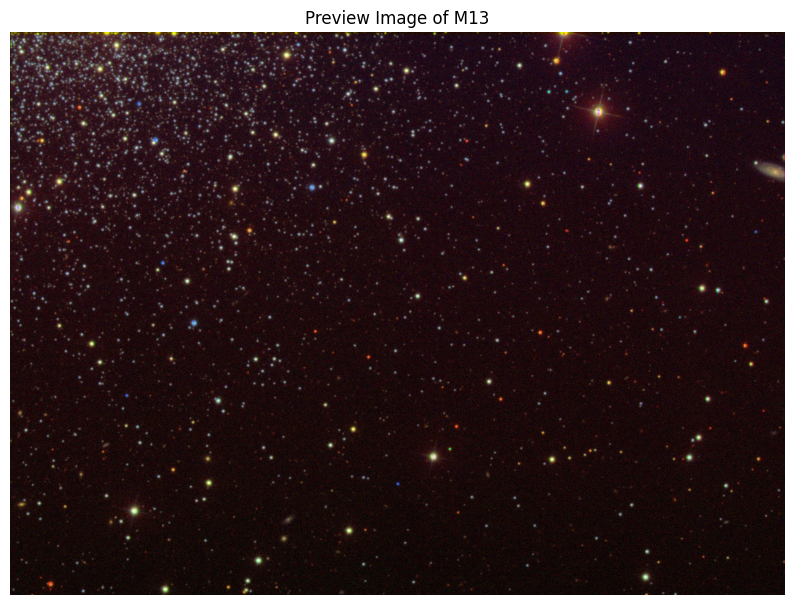

In [8]:
img = mpimg.imread("frame-irg-003226-5-0126.jpg")
plt.figure(figsize=(10, 8))
imgplot = plt.imshow(img)
plt.axis("off")
plt.title("Preview Image of M13")
plt.show()

While the field isn't directly capturing the center of cluster, it will contain enough cluster stars to create a CMD with! We'll now download the full FITS files and select `photoObj-003226-5-0126.fits` due to its CMD congruency. 

Each photoObj FITS file follows the following naming scheme: `photoObj-{RUN}-{CAMCOL}-{FIELD}` where `RUN` is the zero-padded, six-digit identification number for that photometric run, `CAMCOL` is the camera column identifying the scanline within the run, and `FIELD` is field number for that observation. The photoObj file contains the fully calibrated FITS files from the [SDSS Imaging Pipeline](https://www.sdss4.org/dr17/imaging/pipeline/) and other respective measurements such as photometry in all five SDSS filters (u, g, r, i, and z), source classification, and quality flags. There is one photoObj file for each run-camcol-field combination. 

In [9]:
# Masking the data to extract only the full FITS file
new_products = Observations.filter_products(
    products,
    # Specify FITS files only
    productGroupDescription="Minimum Recommended Products",
    # Select photoObj files (ugriz)
    productSubGroupDescription="SDSS Imaging Catalogs",
    # Select photoObj-003226-5-0126.fits
    productFilename="photoObj-003226-5-0126.fits",
)

# Downloading photoObj-003226-5-0126.fits
manifest = Observations.download_products(new_products, verbose=False)

INFO: Found cached file ./mastDownload/SDSS/sdss_image_003226-5-0126/photoObj-003226-5-0126.fits with expected size 8089920. [astroquery.query]


We can now open the file and examine it. For this tutorial, we will focus on the g-band and r-band magnitudes provided in the first file extension. 

The various file extensions are broken down on the [SDSS website](https://data.sdss.org/datamodel/files/BOSS_PHOTOOBJ/RERUN/RUN/CAMCOL/photoObj.html):
- HDU 0: The primary header information.
- HDU 1: The photoObj table. This contains information such as magnitudes, coordinates, and flux.

In [10]:
# Opening file
star_array = fits.open(manifest["Local Path"][0])

# Display header info
star_array.info()

Filename: ./mastDownload/SDSS/sdss_image_003226-5-0126/photoObj-003226-5-0126.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   ()      
  1                1 BinTableHDU    302   2677R x 139C   [19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, J, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 40E, 40E, 5J, 5J, 5E, 5E, 5D, J, J, J, J, J, J, J, E]   


### Creating a Color-Magnitude Diagram of M13

To obtain magnitudes from the FITS file, we'll be using `PSFMAG` from the first file extension. Within `PSFMAG` there are 5 total columns, each one corresponding to the apparent magnitudes in the u, g, r, i, or z filters. We'll extract the g-band magnitudes from the second column and the r-band magnitudes from the third column.

In [11]:
# Sending the PSFMAG data to a numpy array
magnitudes = star_array[1].data["PSFMAG"]
magnitudes = np.array(magnitudes)

# Creating arrays for g-band and r-band magnitudes
g_band = magnitudes[:, 1]
r_band = magnitudes[:, 2]

# Calculating color (g - r)
color_data1 = g_band - r_band

To create a CMD, we simply need to plot the r-band magnitudes against the color (g-r) for these stars!

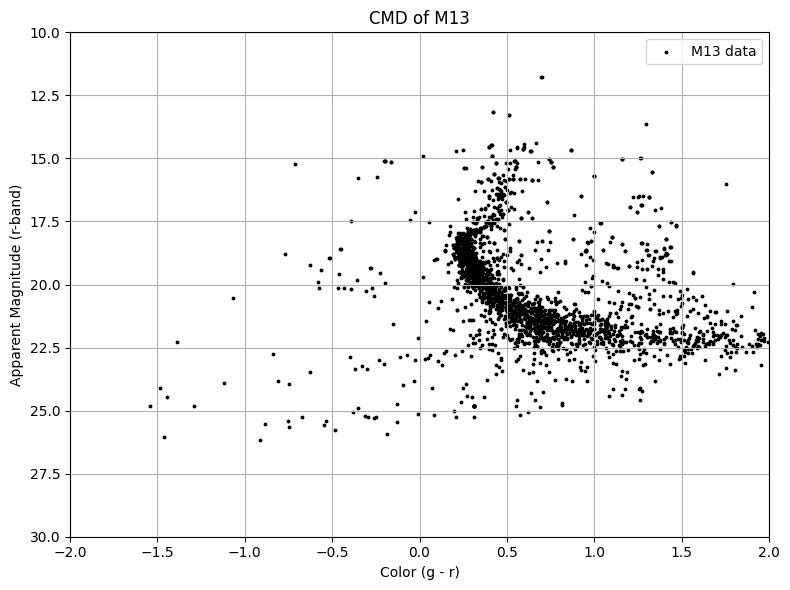

In [12]:
# Plotting the CMD
plt.figure(figsize=(8, 6))
plt.scatter(color_data1, r_band, s=3, color="black", label="M13 data")
plt.ylim(10, 30)
plt.gca().invert_yaxis()
plt.xlim(-2, 2)
plt.title("CMD of M13")
plt.ylabel("Apparent Magnitude (r-band)")
plt.xlabel("Color (g - r)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

*** 
## Finding the Distance to M13 Using Data from Gaia

Gaia was launched by the European Space Agency (ESA) in December 2013. Orbiting at L2, its main purpose is to observe billions of stars to create a 3D map of our galaxy. Gaia provides data such as astrometry, photometry, and radial velocities For more information about Gaia, visit the [ESA website](https://www.esa.int/Science_Exploration/Space_Science/Gaia). 

We'll query Gaia for M13 data using a search radius of 0.375 degrees. This narrows our search so that we focus on the cluster stars rather than foreground stars, allowing us to get a more accurate distance.

The catalog search should take around a minute or so. 

In [13]:
# querying Gaia
coordinates = "16h41m41.24s 36d27m35.5s"  # Coordinates of M13
catalog_data = Catalogs.query_region(
    coordinates, catalog="GaiaDR3", radius=0.375
)

Gaia provides parallax measurements for a wide variety of astronomical objects. Stellar parallax is the apparent shift in position of a nearby star caused by Earth's motion around the Sun.

<figure style="text-align: center;">
  <img src="https://www.astronomy.ohio-state.edu/pogge.1/Ast162/Unit1/Images/parallax_sm.png" alt="Stellar Parallax" width="450px" height="320px"/>
  <figcaption>
  Stellar Parallax Diagram by R. Pogge
  <a href="https://www.astronomy.ohio-state.edu/pogge.1/Ast162/Unit1/distances.html" target="_blank">[8].</a>
  </figcaption>
</figure>

We can determine the distance to these objects from the parallax angle using small-angle approximation:

$$
d = \frac{1}{p}
$$

where $d$ is distance in parsecs and $p$ is parallax in arcseconds. 

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4049: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)


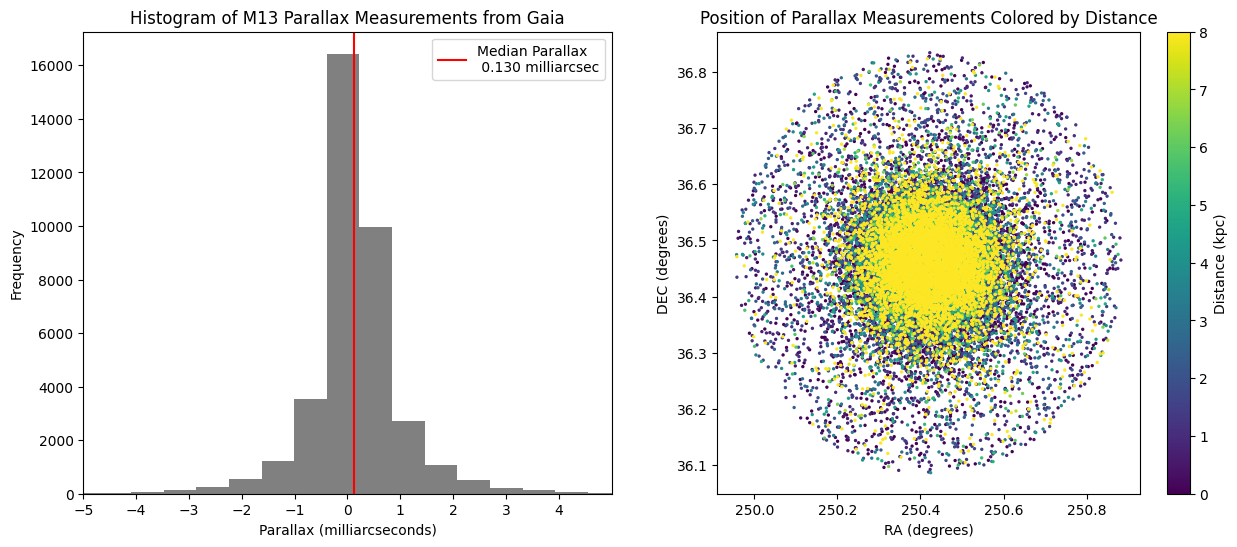

In [14]:
# Extracting parallax measurements from Gaia
parallax = catalog_data["parallax"]  # in milliarcseconds
distance_array = 1 / parallax  # distance array from parallax (kiloparsecs)
ra = catalog_data["ra"]  # right ascension
dec = catalog_data["dec"]  # declination

# Sorting data
sorted_indices = np.argsort(distance_array)
ra_sorted = ra[sorted_indices]
dec_sorted = dec[sorted_indices]
distance_sorted = distance_array[sorted_indices]

# Creating a histogram of the parallax measurements and RA/DEC map
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Histogram
ax[0].hist(parallax, bins=100, color="gray")
ax[0].axvline(
    np.nanmedian(parallax),
    color="red",
    label=f"Median Parallax \n {np.nanmedian(parallax):.3f} milliarcsec",
)
ax[0].set_xlim(-5, 5)
ax[0].set_xticks(np.arange(-5, 5, 1))
ax[0].set_xlabel("Parallax (milliarcseconds)")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Histogram of M13 Parallax Measurements from Gaia")
ax[0].legend()

# RA/DEC map
plot = ax[1].scatter(
    ra_sorted,
    dec_sorted,
    s=2,
    c=distance_sorted,
    cmap="viridis",
    vmin=0,
    vmax=8,
)
cbar = fig.colorbar(plot, ax=ax[1])
cbar.set_label("Distance (kpc)")
ax[1].set_xlabel("RA (degrees)")
ax[1].set_ylabel("DEC (degrees)")
ax[1].set_title("Position of Parallax Measurements Colored by Distance")

plt.show()

The histogram above shows the distribution of the various parallax measurements Gaia made for M13. We'll take the median of these measurements to use as a general distance for the cluster. 

In [15]:
# Finding the median parallax of the data
cluster_median = np.nanmedian(parallax)

# Calculating distance using stellar parallax formula
distance = 1.0 / cluster_median

print(f"Median Parallax: {cluster_median} milliarcseconds")
print(f"Distance to M13: {distance:.4f} kpc")

Median Parallax: 0.1299530647655502 milliarcseconds
Distance to M13: 7.6951 kpc


Therefore, according to Gaia data, the distance to M13 is approximately 7.6951 kpc. We can now use this to convert the isochrones to apparent magnitudes in the next steps. 

***
## Determining the Age of M13 Using Stellar Isochrone Matching

We can determine the approximate age of M13 by plotting its CMD with isochrones of varying ages, and match the best fit isochrone track to the M13 data. 

The isochrones are located in the .txt file `isochrones.txt`. These were the result of generating isochrones from the [PARSEC database](https://stev.oapd.inaf.it/cgi-bin/cmd) with a metallicity of -1.33 dex and ages from 2 billion years old to 14 billion years old in step sizes of 1 billion years. The other settings were left as default. 

Since the SDSS Legacy Survey observed apparent magnitudes, we'll need to convert the absolute magnitudes from the isochrones to apparent magnitudes. We'll use the distance modulus formula since we know the approximate distance to M13 [[9]](https://astronomy.swin.edu.au/cosmos/d/Distance+Modulusx):

$$
m-M=5log_{10}(\frac{d}{10})
$$

where $m$ is apparent magnitude, $M$ is absolute magnitude, and $d$ is the distance to the object in parsecs. 

In [16]:
# Distance to M13
d = distance * 10**3  # parsecs


# Converting absolute magnitudes from isochrones to apparent
def app_mag(M):
    return M + 5 * np.log10(d / 10)

In [17]:
# Importing isochrone .txt file
parsec_data = pd.read_csv(
    "isochrones.txt", sep=r"\s+", comment="#", header=None
)

# Converting the data file to an array
parsec_data = np.array(parsec_data)

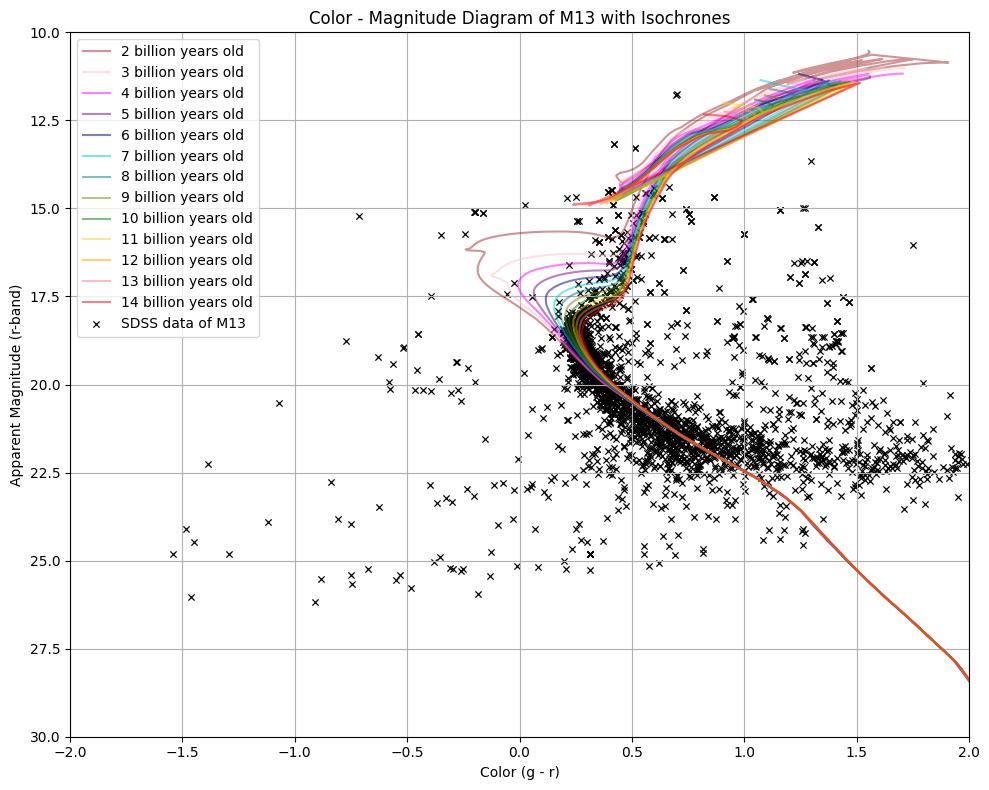

In [18]:
# The isochrone data file is broken up into age bins
log_age = [
    9.30103,
    9.47712,
    9.60206,
    9.69897,
    9.77815,
    9.84510,
    9.90309,
    9.95424,
    10.00000,
    10.04139,
    10.07918,
    10.11394,
    10.14613,
]

# Setting up a dictionary
age_data = {}

# Looping through .txt file to separate by age
for i, age in enumerate(log_age, start=1):
    age_data[f"age{i}"] = parsec_data[parsec_data[:, 2] == age]

# Extracting g and r magnitudes, applying distance modulus formula
# Setting up arrays
r_data = []
g_data = []
color_data2 = []

# Sending g and r magnitudes and color to an array
for i in range(1, len(log_age) + 1):
    data = age_data[f"age{i}"]
    g_mag = app_mag(data[:, 29])
    r_mag = app_mag(data[:, 30])
    color = g_mag - r_mag

    r_data.append(r_mag)
    g_data.append(g_mag)
    color_data2.append(color)

# Plotting the isochrones
color = [
    "brown",
    "pink",
    "magenta",
    "purple",
    "navy",
    "darkturquoise",
    "teal",
    "olive",
    "green",
    "gold",
    "orange",
    "lightcoral",
    "red",
]
fig, ax = plt.subplots(figsize=(10, 8))
for i, j, k, r in zip(color_data2, r_data, log_age, color):
    ax.plot(
        i,
        j,
        alpha=0.5,
        label=f"{(10**k) / 1e9:.0f} billion years old",
        color=r,
    )

# Plotting the data
ax.scatter(
    color_data1,
    r_band,
    marker="x",
    linewidth=0.9,
    s=20,
    color="black",
    label="SDSS data of M13",
)
ax.set_ylabel("Apparent Magnitude (r-band)")
ax.set_xlabel("Color (g - r)")
ax.set_title("Color - Magnitude Diagram of M13 with Isochrones")
ax.set_ylim(10, 30)
ax.set_xlim(-2, 2)
ax.invert_yaxis()
ax.legend(fontsize=10)
ax.grid(True)
fig.tight_layout()

While the isochrones extend beyond 27.5 r-band magnitude, the M13 data doesn't quite reach this far due to the limiting magnitude of the SDSS camera. 

We'll create a zoomed-in plot to further study the terminal age main sequence (TAMS) and main sequence turnoff phases. 

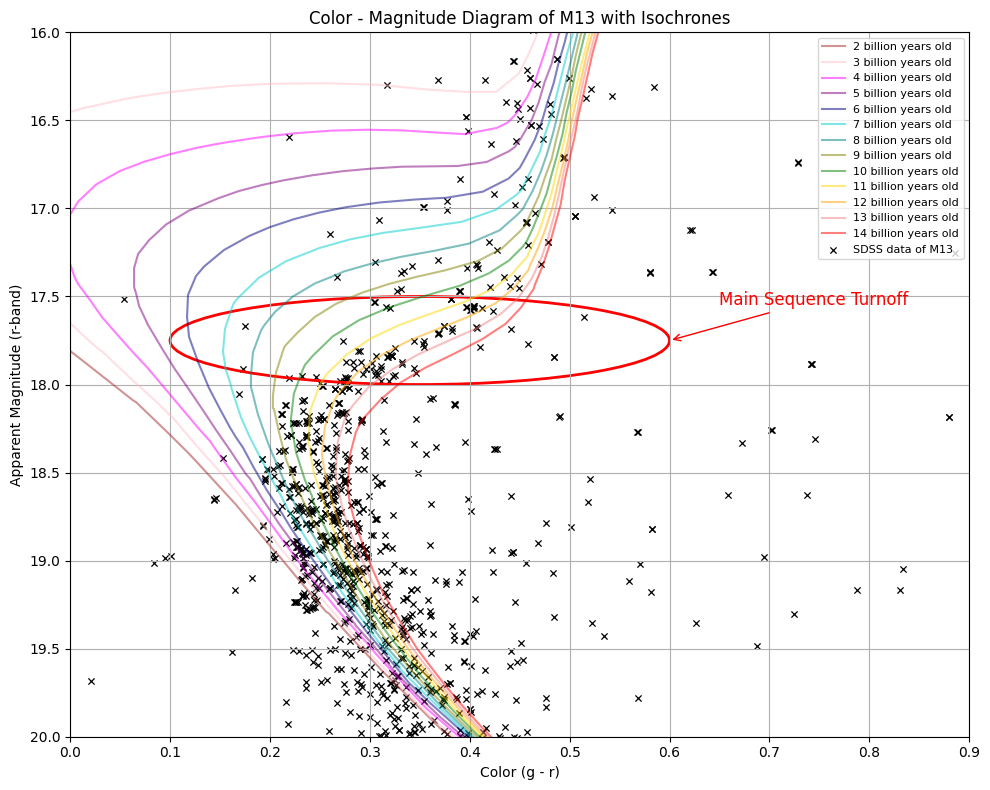

In [19]:
# Replotting with different x and y limits
ax.set_xlim(0, 0.9)
ax.set_ylim(16, 20)
ax.invert_yaxis()
ax.legend(fontsize=8)

# Adding annotation for main sequence turnoff
circle = plt.Circle(
    (0.35, 17.75),
    0.25,
    color="red",
    fill=False,
    linewidth=2,
    label="Main Sequence Turnoff",
)
ax.add_patch(circle)
ax.annotate(
    "Main Sequence Turnoff",
    xy=(0.6, 17.75),
    xytext=(0.6 + 0.05, 17.75 - 0.2),
    arrowprops=dict(arrowstyle="->", color="red"),
    fontsize=12,
    color="red",
)

fig

From examining the data and isochrones within the main sequence turnoff circle, it appears the data follow the orange track, indicating the cluster is approximately **12 billion years old**. This isn't far from the 11.65 billion year old estimate made by D. Forbes and T. Bridges in *Accreted Versus in situ Milky Way Globular Clusters* [[5]](https://academic.oup.com/mnras/article/404/3/1203/1049211?login=true#92596831).

***
## End of Tutorial

Congratulations, you now know how to determine the age of a star cluster from isochrone matching using the SDSS Legacy Imaging Survey! 

***
## Exercises
Now it's your turn to determine the age of **Messier 3**! M3 has a metallicity of -1.34 dex, which is nearly identical to M13, so you can use the same isochrone file `isochrones.txt` [[5]](https://academic.oup.com/mnras/article/404/3/1203/1049211?login=true#92596831). 

There are six different fields available for M3, you can choose whichever one visually has the best looking CMD when plotted, so answers can vary slightly.  

In [20]:
# Query SDSS Legacy Imaging Survey for M3 data

In [21]:
# View available products

In [22]:
# Download products

In [23]:
# Plot CMD of M3

In [24]:
# Find distance to M3 using Gaia

In [25]:
# Plot CMD with isochrones

***
## Exercise Solutions

In [26]:
# Query SDSS Legacy Imaging Survey for M3 data

obs_table2 = Observations.query_criteria(
    objectname="M3", provenance_name="SDSS Legacy Imaging"
)

# Displaying the table
obs_table2

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str19,str11,str4,str9,str7,str13,str5,str24,float64,float64,str5,str18,int64,float64,float64,float64,float64,float64,str51,float64,str3,str1,int64,str197,str61,str61,str6,bool,float64,str9,str9,str9,float64
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,004649-3-0146,FIELD,sdss_image_004649-3-0146,205.490651819,28.085188819,image,SDSS Collaboration,3,53148.292544791664,53148.29648631315,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 205.37706850623056 27.988627871719682 205.42159486278487 28.210231791472925 205.60441753406982 28.181547849750537 205.5595262109013 27.960003124274728 205.37706850623056 27.988627871719682,mast:SDSS/sdss/imaging/4649/3/146/frame-irg-004649-3-0146.jpg,mast:SDSS/sdss/imaging/4649/3/146/photoObj-004649-3-0146.fits,PUBLIC,False,nan,297016644,877000851,877000851,662.4582359914772
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,004649-4-0145,FIELD,sdss_image_004649-4-0145,205.406518204,28.5247113578,image,SDSS Collaboration,3,53148.29212997685,53148.296071382596,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 205.29256303409997 28.428055614125235 205.33703079237077 28.649688467782617 205.52066047872054 28.621163594869746 205.47581916619885 28.399590727008345 205.29256303409997 28.428055614125235,mast:SDSS/sdss/imaging/4649/4/145/frame-irg-004649-4-0145.jpg,mast:SDSS/sdss/imaging/4649/4/145/photoObj-004649-4-0145.fits,PUBLIC,False,nan,297060525,877069703,877069703,243.55720045892613
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,004646-3-0082,FIELD,sdss_image_004646-3-0082,205.656308884,28.2721588412,image,SDSS Collaboration,3,53147.302064814816,53147.306005641854,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 205.5423832905099 28.175729968111437 205.58730682675895 28.39725991057679 205.77041863016308 28.368384857511558 205.7251269725764 28.146914991664634 205.5423832905099 28.175729968111437,mast:SDSS/sdss/imaging/4646/3/82/frame-irg-004646-3-0082.jpg,mast:SDSS/sdss/imaging/4646/3/82/photoObj-004646-3-0082.fits,PUBLIC,False,nan,298416340,886143838,886143838,108.59459460943275
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,004649-3-0147,FIELD,sdss_image_004649-3-0147,205.657671944,28.0589023561,image,SDSS Collaboration,3,53148.29295949074,53148.29690089648,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 205.54394470283248 27.962474450750673 205.5888145108555 28.184009933873277 205.77158117037538 28.15512819922499 205.72634720424867 27.933652309716898 205.54394470283248 27.962474450750673,mast:SDSS/sdss/imaging/4649/3/147/frame-irg-004649-3-0147.jpg,mast:SDSS/sdss/imaging/4649/3/147/photoObj-004649-3-0147.fits,PUBLIC,False,nan,297003774,876981454,876981454,707.4595416072544
science,SDSS,SDSS Legacy Imaging,SDSS Camera,SDSS,u;g;r;i;z,OPTICAL,004649-3-0145,FIELD,sdss_image_004649-3-0145,205.323553735,28.1112790851,image,SDSS Collaboration,3,53148.29213043981,53148.296071498335,53.907456,304.79999999999995,1083.3000000000002,Sloan Digital Sky Survey (SDSS) Legacy Imaging Data,55571.0,N/A,--,--,POLYGON 205.2100784323227 28.01456697081828 205.25425945894472 28.23622770285823 205.43721195883117 28.207789375478082 205.392665007371 27.986187458585785 205.2100784323227 28.01456697081828,mast:SDSS/sdss/imaging/4649/3/145/frame-irg-004649-3-0145.jpg,mast:SDSS/

In [27]:
# Download products
products2 = Observations.get_product_list(obs_table2)

# Download products
new_products2 = Observations.filter_products(
    products2,
    # Specify FITS files only
    productGroupDescription="Minimum Recommended Products",
    # Select photoObj files (ugriz)
    productSubGroupDescription="SDSS Imaging Catalogs",
    # Select photoObj-003226-5-0126.fits
    productFilename="photoObj-004649-4-0145.fits",
)

# Downloading photoObj-003226-5-0126.fits
manifest2 = Observations.download_products(new_products2)

INFO: Found cached file ./mastDownload/SDSS/sdss_image_004649-4-0145/photoObj-004649-4-0145.fits with expected size 7848000. [astroquery.query]


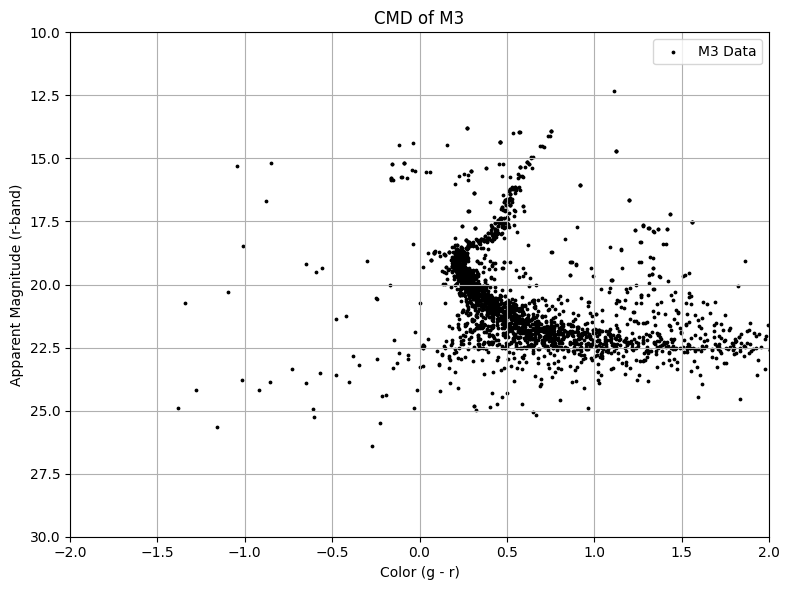

In [28]:
# Plot CMD of M3

# Opening file
star_array2 = fits.open(manifest2["Local Path"][0])

# Sending the PSFMAG data to a numpy array
magnitudes2 = star_array2[1].data["PSFMAG"]
magnitudes2 = np.array(magnitudes2)

# Creating arrays for g-band and r-band magnitudes
g_band2 = magnitudes2[:, 1]
r_band2 = magnitudes2[:, 2]

# Calculating color (g - r)
color_data3 = g_band2 - r_band2

# Plotting the CMD
plt.figure(figsize=(8, 6))
plt.scatter(color_data3, r_band2, s=3, color="black", label="M3 Data")
plt.ylim(10, 30)
plt.gca().invert_yaxis()
plt.xlim(-2, 2)
plt.title("CMD of M3")
plt.ylabel("Apparent Magnitude (r-band)")
plt.xlabel("Color (g - r)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4049: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)
/tmp/ipykernel_2774/104144980.py:49: UserWarning: Adding colorbar to a different Figure <Figure size 1500x600 with 3 Axes> than <Figure size 1000x800 with 1 Axes> which fig.colorbar is called on.
  cbar2 = fig.colorbar(plot2, ax=ax2[1])


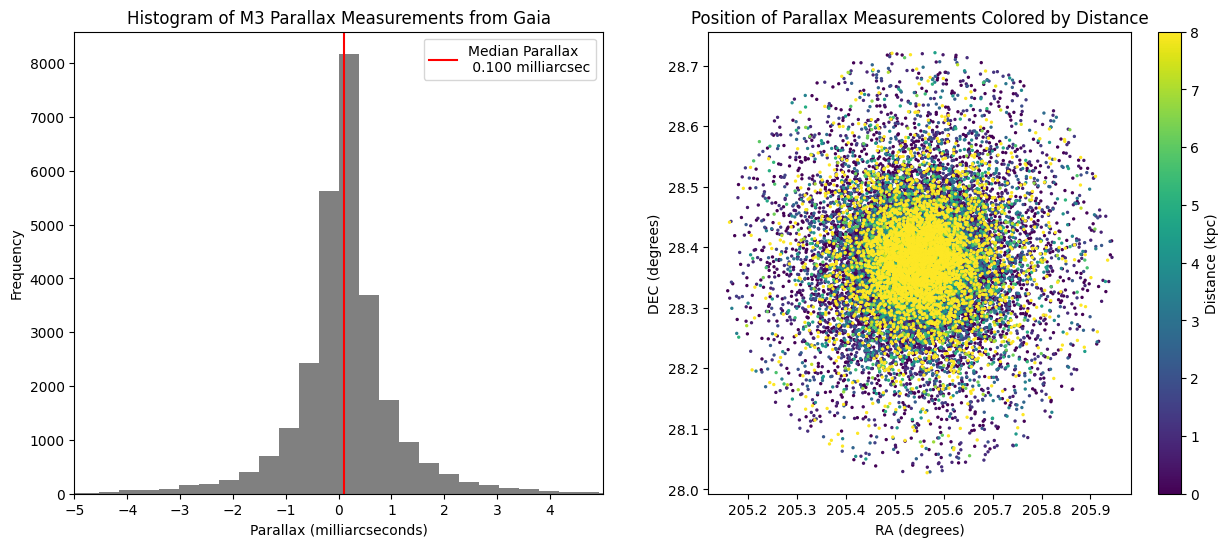

Median Parallax: 0.09967599714927582 milliarcseconds
Distance to M3: 10.0325 kpc


In [29]:
# Find distance to M3 using Gaia

# querying Gaia
coordinates2 = "13h42m11.80s 28d22m31.69s"  # Coordinates of M3

catalog_data2 = Catalogs.query_region(
    coordinates2, catalog="GaiaDR3", radius=0.35
)

# Extracting parallax measurements from Gaia
parallax2 = catalog_data2["parallax"]  # in milliarcseconds
distance_array2 = 1 / parallax2  # distance array from parallax (kiloparsecs)
ra2 = catalog_data2["ra"]  # right ascension
dec2 = catalog_data2["dec"]  # declination

# Sorting data
sorted_indices2 = np.argsort(distance_array2)
ra_sorted2 = ra2[sorted_indices2]
dec_sorted2 = dec2[sorted_indices2]
distance_sorted2 = distance_array2[sorted_indices2]

# Creating a histogram of the parallax measurements and RA/DEC map
fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Histogram
ax2[0].hist(parallax2, bins=100, color="gray")
ax2[0].axvline(
    np.nanmedian(parallax2),
    color="red",
    label=f"Median Parallax \n {np.nanmedian(parallax2):.3f} milliarcsec",
)
ax2[0].set_xlim(-5, 5)
ax2[0].set_xticks(np.arange(-5, 5, 1))
ax2[0].set_xlabel("Parallax (milliarcseconds)")
ax2[0].set_ylabel("Frequency")
ax2[0].set_title("Histogram of M3 Parallax Measurements from Gaia")
ax2[0].legend()

# RA/DEC map
plot2 = ax2[1].scatter(
    ra_sorted2,
    dec_sorted2,
    s=2,
    c=distance_sorted2,
    cmap="viridis",
    vmin=0,
    vmax=8,
)
cbar2 = fig.colorbar(plot2, ax=ax2[1])
cbar2.set_label("Distance (kpc)")
ax2[1].set_xlabel("RA (degrees)")
ax2[1].set_ylabel("DEC (degrees)")
ax2[1].set_title("Position of Parallax Measurements Colored by Distance")

plt.show()

# Finding the median parallax of the data
cluster_median2 = np.nanmedian(parallax2)

# Calculating distance using stellar parallax formula
distance2 = 1.0 / cluster_median2

print(f"Median Parallax: {cluster_median2} milliarcseconds")
print(f"Distance to M3: {distance2:.4f} kpc")

# Distance to M3
d2 = distance2 * 10**3  # parsecs

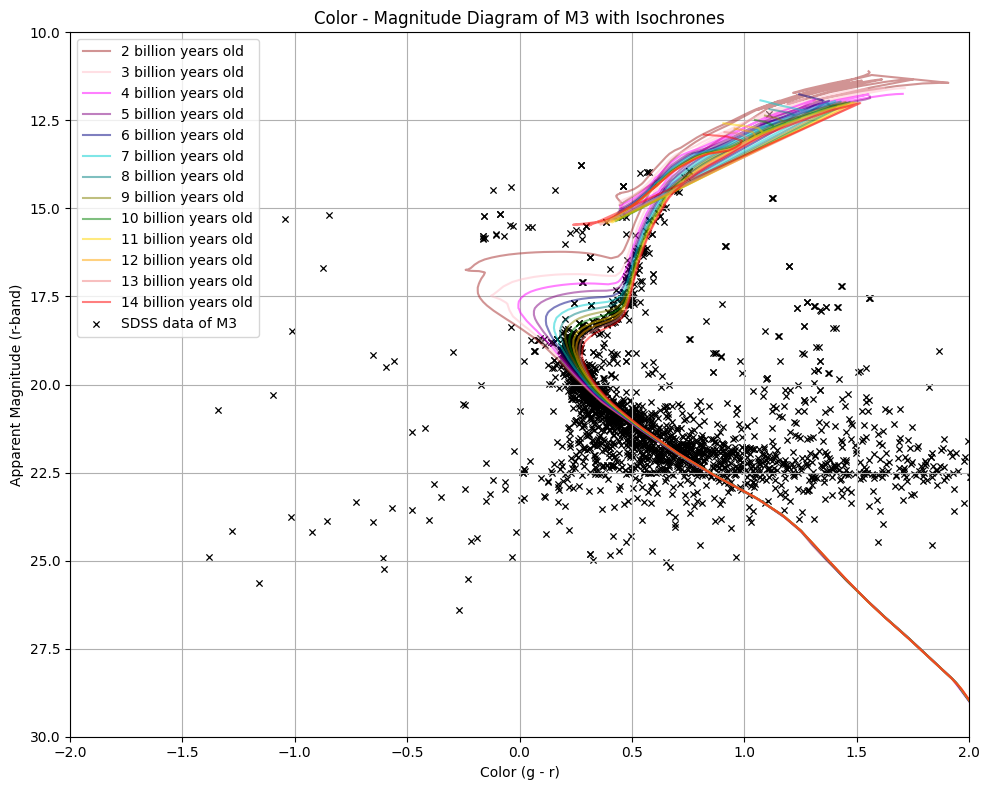

In [30]:
# Plot CMD with isochrones


def app_mag2(M):
    return M + 5 * np.log10(d2 / 10)


r_data2 = []
g_data2 = []
color_data4 = []

for i in range(1, len(log_age) + 1):
    data = age_data[f"age{i}"]
    g_mag = app_mag2(data[:, 29])
    r_mag = app_mag2(data[:, 30])
    color2 = g_mag - r_mag

    r_data2.append(r_mag)
    g_data2.append(g_mag)
    color_data4.append(color2)

fig, ax = plt.subplots(figsize=(10, 8))
for i, j, k, r in zip(color_data4, r_data2, log_age, color):
    ax.plot(
        i,
        j,
        alpha=0.5,
        label=f"{(10**k) / 1e9:.0f} billion years old",
        color=r,
    )

# Plotting the data
ax.scatter(
    color_data3,
    r_band2,
    marker="x",
    linewidth=0.9,
    s=20,
    color="black",
    label="SDSS data of M3",
)
ax.set_ylabel("Apparent Magnitude (r-band)")
ax.set_xlabel("Color (g - r)")
ax.set_title("Color - Magnitude Diagram of M3 with Isochrones")
ax.set_ylim(10, 30)
ax.set_xlim(-2, 2)
ax.invert_yaxis()
ax.legend(fontsize=10)
ax.grid(True)
fig.tight_layout()

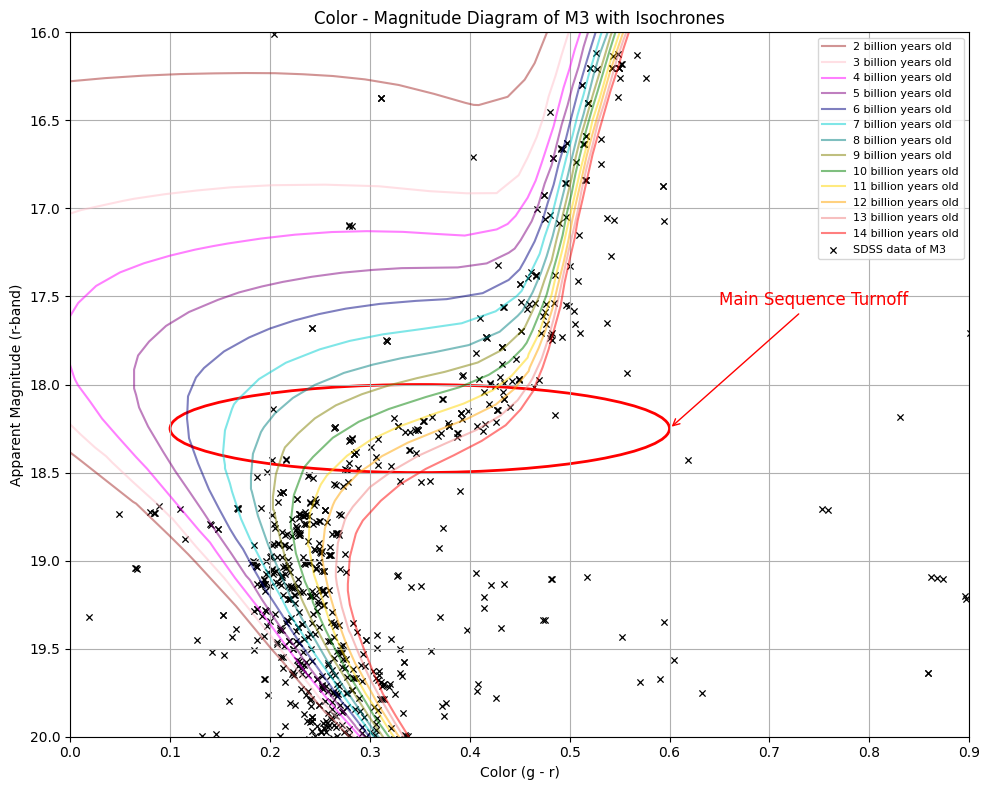

In [31]:
# Replotting with different x and y limits
ax.set_xlim(0, 0.9)
ax.set_ylim(16, 20)
ax.invert_yaxis()
ax.legend(fontsize=8)

# Adding annotation for main sequence turnoff
circle = plt.Circle(
    (0.35, 18.25),
    0.25,
    color="red",
    fill=False,
    linewidth=2,
    label="Main Sequence Turnoff",
)
ax.add_patch(circle)
ax.annotate(
    "Main Sequence Turnoff",
    xy=(0.6, 18.25),
    xytext=(0.6 + 0.05, 17.75 - 0.2),
    arrowprops=dict(arrowstyle="->", color="red"),
    fontsize=12,
    color="red",
)

fig

**Results:**
The data for M3 appear to fit between the yellow and orange lines. Therefore, M3 is between 11-12 billion years old! 

This matches the [age estimates](https://www.kopernik.org/images/archive/m3.htm) of approximately 8-11.4 billion years.

***
## Addtional Resources

Additional resources are linked below:
- [SDSS Legacy Archive at MAST](https://archive.stsci.edu/missions-and-data/sdss)
- [SDSS Legacy Archive at MAST User Manual](https://outerspace.stsci.edu/display/SDSS/The+SDSS+Legacy+Archive+at+MAST)
- [SDSS Legacy Imaging Archive User Manual](https://outerspace.stsci.edu/display/SDSS/Legacy+Imaging)
- [SDSS Imaging Documentation](https://www.sdss.org/dr18/imaging/)
- [SDSS Voyages HR Diagram Tutorial](https://voyages.sdss.org/expeditions/expedition-to-the-milky-way/star-clusters/hr-diagrams/)
- [astroquery.mast User Manual](https://astroquery.readthedocs.io/en/latest/mast/mast.html)
- [MAST API](https://mast.stsci.edu/api/v0/index.html)

## Citations

If you use data from MAST for published research, please see the following links for information on which citations to include in your paper:

* [Citing SDSS](https://sdss.org/collaboration/citing-sdss/)
* [Citing MAST](https://archive.stsci.edu/publishing/mission-acknowledgements)
* [Citing astropy](https://www.astropy.org/acknowledging.html)

## About this Notebook

**Author(s):** Natalie Haugen (nhaugen@terpmail.umd.edu) and Julie Imig (jimig@stsci.edu) <br>
**Keyword(s):** Tutorial, SDSS, SDSS Legacy Imaging Survey, stars, HR diagram, CMD, imaging <br>
**First published:** July 2025 <br>
**Last updated:** July 2025 <br>

***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/style-guides/master/guides/images/stsci-logo.png" alt="Space Telescope Logo" width="200px"/>